## Pool of high density
Frames and movie

In [11]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.animation as animation
import matplotlib.gridspec as gspec
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import seaborn as sns
import xarray as xr
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [12]:
# Grid, state and tracers datasets of base case
grid_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

grid_fileNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc'

state_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'

ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/ptracersGlob.nc'
RhoRef = 999.79998779 

In [4]:
with Dataset(grid_file, 'r') as nbl:
    Z = nbl.variables['RC'][:]
    X = nbl.variables['X'][:]
    Y = nbl.variables['Y'][:]
    hFacC = nbl.variables['HFacC'][:]
    rA = nbl.variables['rA'][:]
    Depth = nbl.variables['Depth'][:]
    
hfac = np.ma.masked_values(hFacC, 0)
maskC = np.ma.getmask(hfac)

with Dataset(grid_fileNoC, 'r') as nbl:
    hFacCNoC = nbl.variables['HFacC'][:]

hfac = np.ma.masked_values(hFacCNoC, 0)
maskCNoC = np.ma.getmask(hfac)

with Dataset(state_file, 'r') as nbl:
    iters = nbl.variables['iter'][:]

In [22]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 4D arrays 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T) + beta*(S))
    return rho

def call_rho(tslice,state,zslice,yslice,xslice):
    T = state.Temp.isel(T=tslice,Z=zslice,X=xslice,Y=yslice)
    S = state.S.isel(T=tslice,Z=zslice,X=xslice,Y=yslice)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

In [23]:
# Cross-shelf velocity, Plot1
def Plot1(gs_ax,t,Tr,xx,zz,textt, Trmin=0,Trmax=2): 
    '''gs_ax: grid handle
       Tr: tracer concentration sliced in x-z (nt,nz,nx)
       t: time index.
       xx: x coords, sliced
       yy: y coords, sliced
    '''
    ax = plt.subplot(gs_ax)
    
    csU = np.linspace(Trmin,Trmax,num=31)
    csU2 = np.linspace(Trmin,Trmax,num=16)
    
    mesh = ax.contourf(xx/1000,zz,Tr,
                       csU,
                       cmap=cmap_name)
    
    ax.set_facecolor((180/255.0, 175/255.0, 175/255.0))
    ax.text(0.1,-0.3,'%s at day %1.1f'%(textt, t/2.),fontsize=16,transform=ax.transAxes)
    ax.set_ylabel('Depth (m)',labelpad=0.3)
    ax.tick_params(axis='y', pad=1)
    
def Plot2(gs_ax,t,Tr,yy,zz,Trmin=0,Trmax=2): 
    '''gs_ax: grid handle
       Tr_slice: tracer concentration sliced in y-z (nt,nz,ny)
       tslice: advective phase slice to average over.
       xind: cross-shore index of the plot
    '''
    ax = plt.subplot(gs_ax)
    
    csU = np.linspace(Trmin,Trmax,num=31)
    csU2 = np.linspace(Trmin,Trmax,num=16)
    
    mesh = ax.contourf(yy/1000,zz,Tr,
                       csU,
                       cmap=cmap_name)
    
    if tt == 0:
        cbar_ax = ff.add_axes([0.91, 0.62, 0.016, 0.26])
        cb = plt.colorbar(mesh, cax=cbar_ax,ticks=[np.linspace(Trmin, Trmax,8) ],format='%.1f')
        cb.ax.yaxis.set_tick_params(pad=1)

        ax.set_facecolor((180/255.0, 175/255.0, 175/255.0))
    
    ax.set_facecolor((205/255.0, 201/255.0, 201/255.0))
    #ax.set_ylabel('Depth (m)',labelpad=0.3)
    ax.set_xlabel('Cross-shelf distance (km)',labelpad=0.3)
    ax.tick_params(axis='y', pad=1)
    
def Plot3(ff,gs_ax,t,ConcFilt,xx,yy,xind,yind,depth,Trmin=0,Trmax=2):
    
    ax = plt.subplot(gs_ax)
    
    mesh = ax.contourf(xx/1000,yy/1000,ConcFilt,
                       21, 
                      vmax=Trmax, 
                      vmin=Trmin,
                      cmap=cmap_name2)
    
       
    ax.set_facecolor((180/255.0, 175/255.0, 175/255.0))
    
    ax.text(0.02,0.9,'Shelf bottom',transform=ax.transAxes,color='w')
    SB = ax.contour(xx/1000,yy/1000,
                    depth,
                    [50,75,100,125,150,200,250,300,350,400,450,500],
                    colors=['0.5','0.5','0.5','0.5','0.1','0.5','0.5','0.5','0.5','0.5','0.5','0.5'],
                    linewidths=[0.75] )
    
    
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    ax.set_xlabel('Alongshelf distance (km)',labelpad=0.3)
    ax.set_ylabel('Cross-shelf distance (km)',labelpad=0.3)

In [24]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, sbdepth)
    return(bathyMasked.mask)

def ConcAreaFunc(Tr, hfac, ra, bathy, nz, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = (np.ones(np.shape(BottomInd))*(nz-1) - BottomInd) # Get index of unreversed z axis
  
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[int(BottomInd[i,j]),i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (np.ma.masked_array(ConcFiltered, mask=maskShelf))


In [25]:
def next_frame(time,ff,state, Trmin=78, Trmax=300,textt = 'Oxygen concentration ($\mu mol/kg$)'):
    
    tt = starttime + time 
        
    dens1 = call_rho(tt,state,zslice,yind,xslice)
    tr_plot1 = np.ma.masked_array(dens1, maskC[zslice, yind, xslice])
    print(np.nanmin(tr_plot1),np.nanmax(tr_plot1))

    dens2 = call_rho(tt,state,zslice_2,yslice,xind)
    tr_plot2 = np.ma.masked_array(dens2, maskC[zslice_2,yslice, xind])
    print(np.nanmin(tr_plot2),np.nanmax(tr_plot2))

    dens3 = call_rho(tt,state,slice(0,104),slice(0,360),slice(0,616))
    concFilt = ConcAreaFunc(dens3,hFacC,rA,Depth,104,sbdepth=-152.5)
    print(np.nanmin(dens3),np.nanmax(dens3))

    gs0 = gspec.GridSpec(2, 1, height_ratios=[0.5,1], hspace=0)
    gs01 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0],width_ratios=[1,0.4], wspace=0.12)
    

    Plot1(gs01[0],tt,tr_plot1-1000,X[xslice],Z[zslice],textt, Trmin=Trmin, Trmax=Trmax)
    Plot2(gs01[1],tt,tr_plot2-1000,Y[yslice],Z[zslice_2], Trmin=Trmin, Trmax=Trmax)
    Plot3(ff,gs0[1],tt,concFilt[yslice_bac,xslice_bac]-1000,X[xslice_bac],Y[yslice_bac],
          xind,yind,Depth[yslice_bac,xslice_bac],
          Trmin=Trmin,Trmax=Trmax)
   
    #plt.tight_layout()



1020.6758112695696 1021.245405035092
1017.9963473845304 1021.2300100930969
999.79998779 1024.3550752480828
1020.6760726860855 1021.2488800357588
1017.9963473845304 1021.2298094332245
999.79998779 1024.3550125709708
1020.6763261879429 1021.256692036521
1017.9963473845304 1021.2282330194707
999.79998779 1024.3549424447683
1020.6765689817328 1021.2684704451318
1017.9963473845304 1021.2238597050597
999.79998779 1024.354885645454
1020.6768029297278 1021.2876036665822
1017.9963473845304 1021.316871841076
999.79998779 1024.354820116737


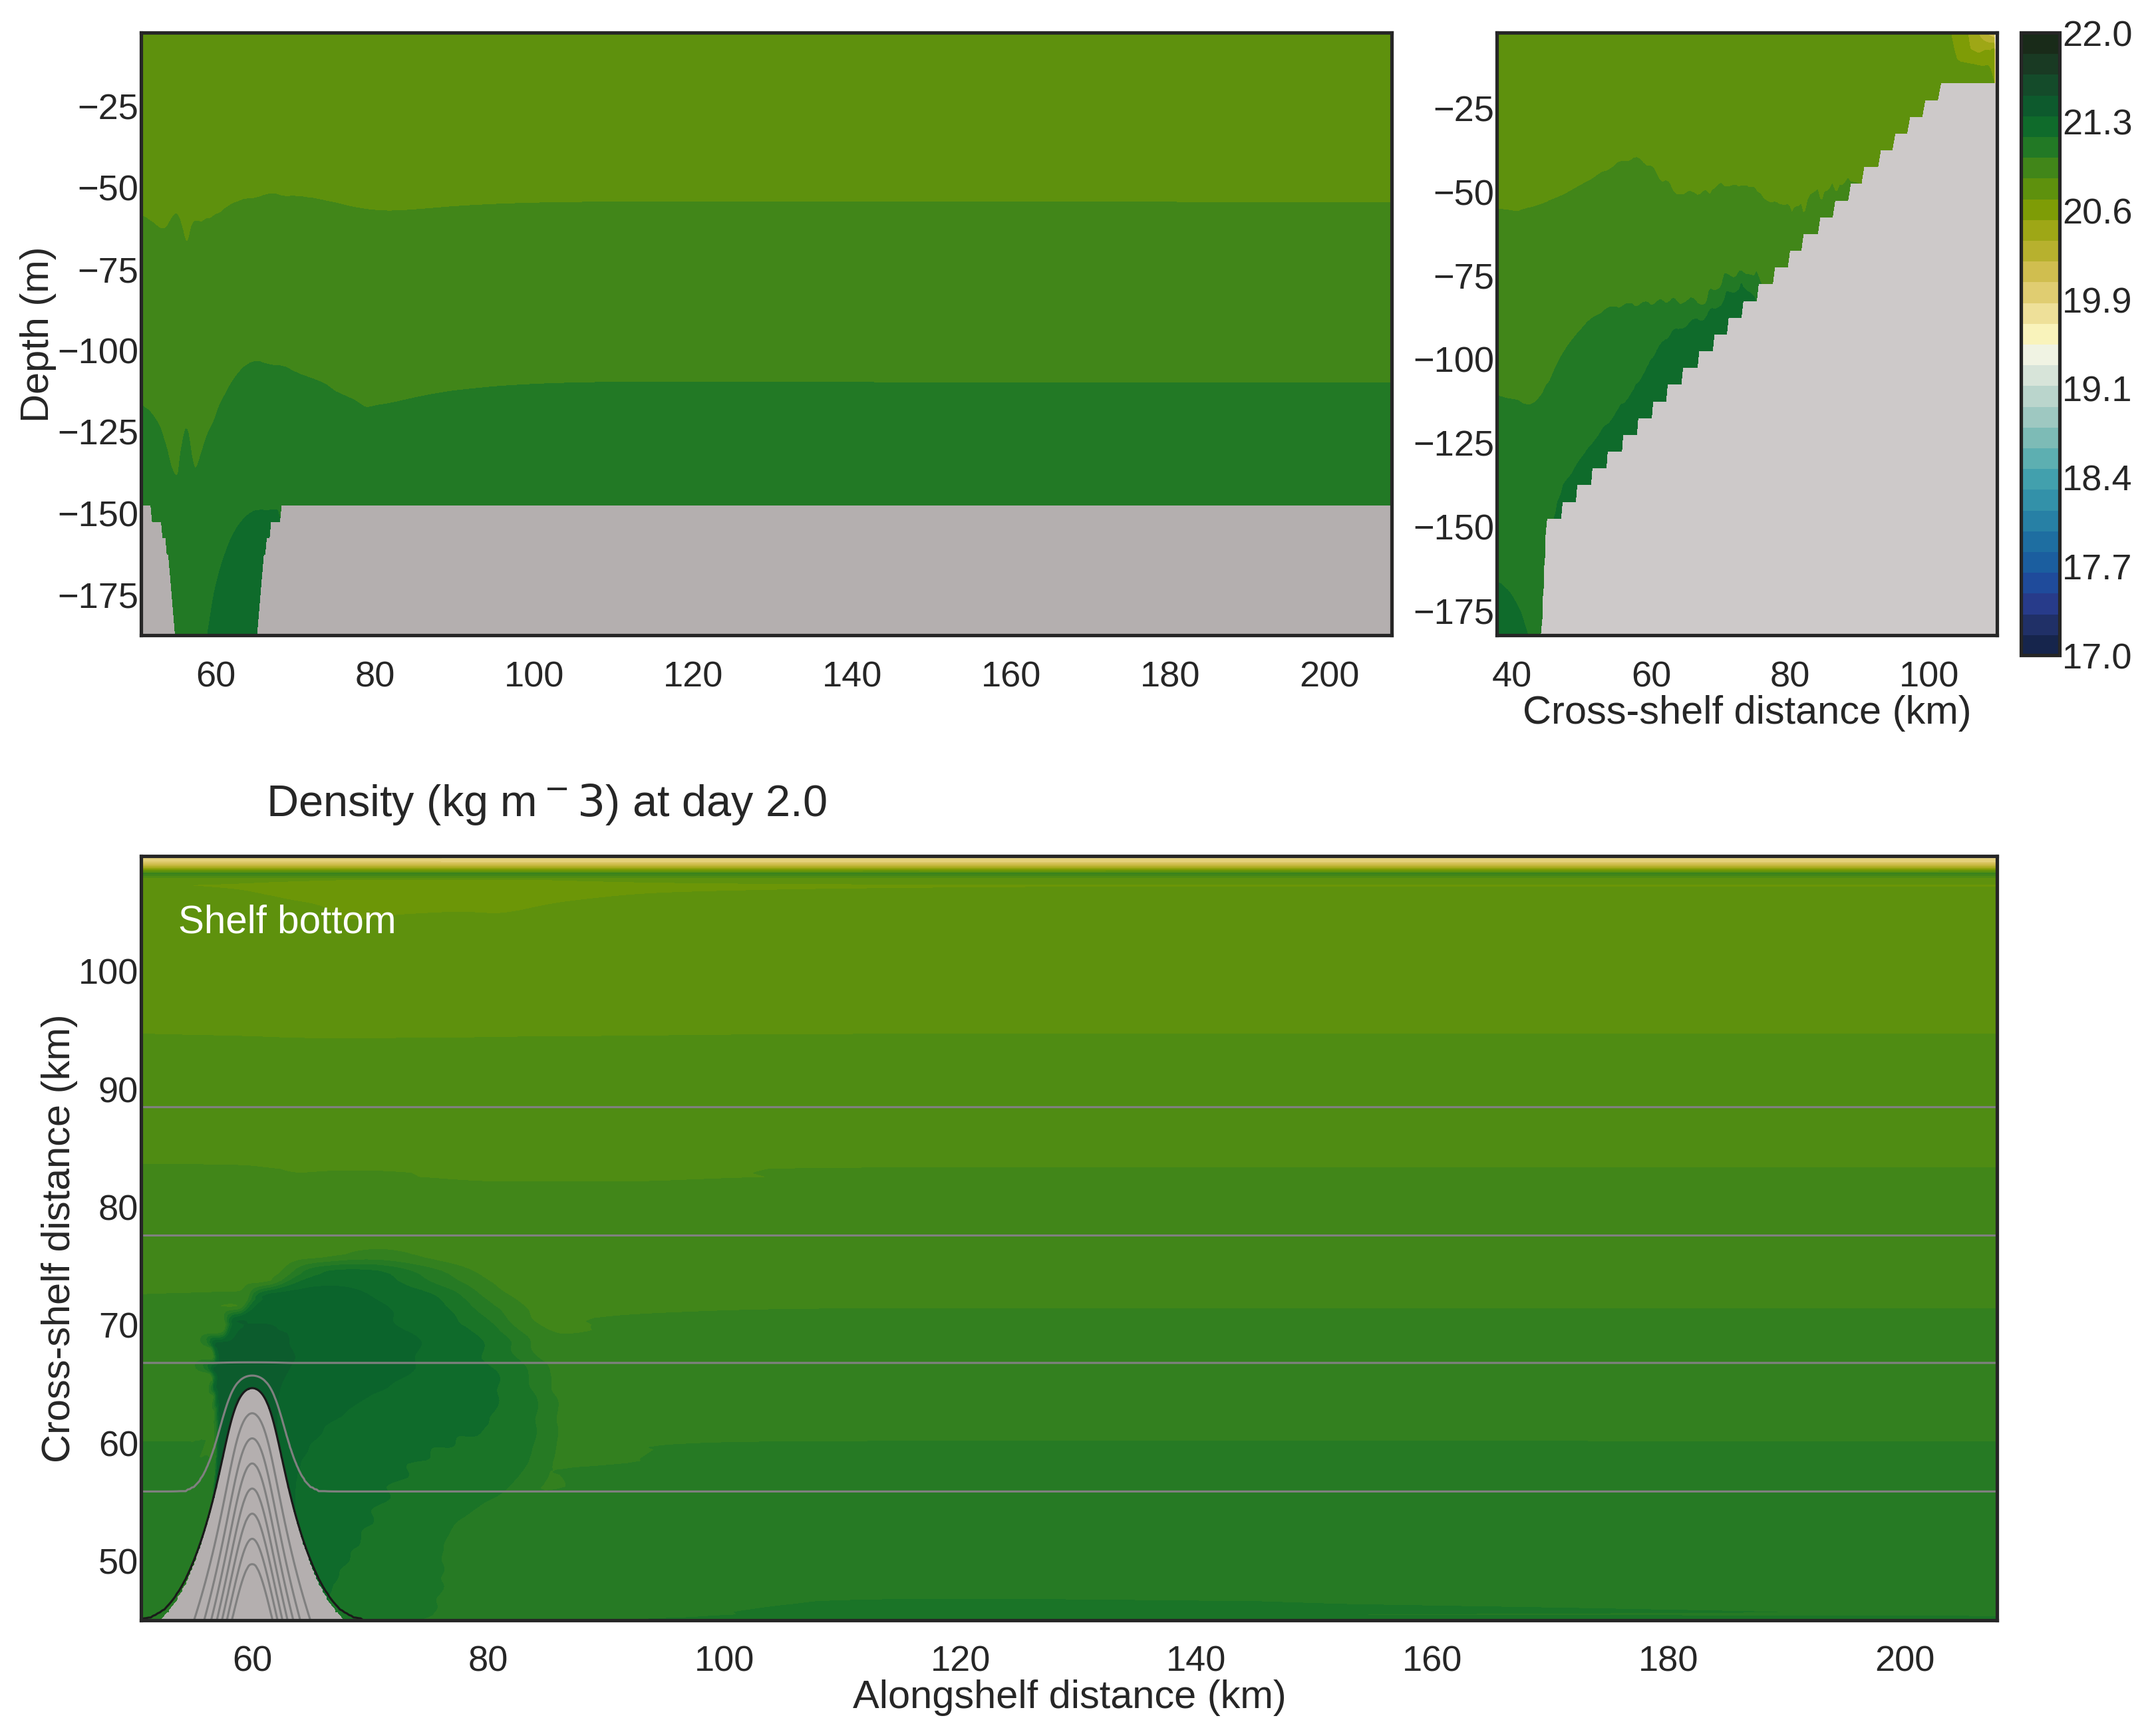

In [28]:
xslice=slice(120,500)
yslice=slice(100,360)

xind = 240
yind = 131 # y index for alongshore cross-section
zind = 38

zslice = slice(0,38)

# plot2
zslice_2 = slice(0,37)

# plot 3
yslice_bac = slice(129,360)
xslice_bac = slice(120,500)

# frames for beamer animation
dpi = 300

cmap_name = cmo.cm.delta
cmap_name2 = cmo.cm.delta
sns.set_context('talk')
sns.set_style('white')

title_text = 'Density (kg m$^-3$)'
plt.rcParams['font.size'] = 14.0

starttime = 0

ff = plt.figure(figsize=(12,12),dpi=dpi)
   
for tt in range(5):
    
    next_frame(tt,ff,state, textt=title_text, Trmin=1017-1000, Trmax=1022-1000)
    frame_name2 = ('frames/dens_AST_tt%02d.png' %tt) 
    plt.savefig(frame_name2,  format='png', bbox_inches='tight')



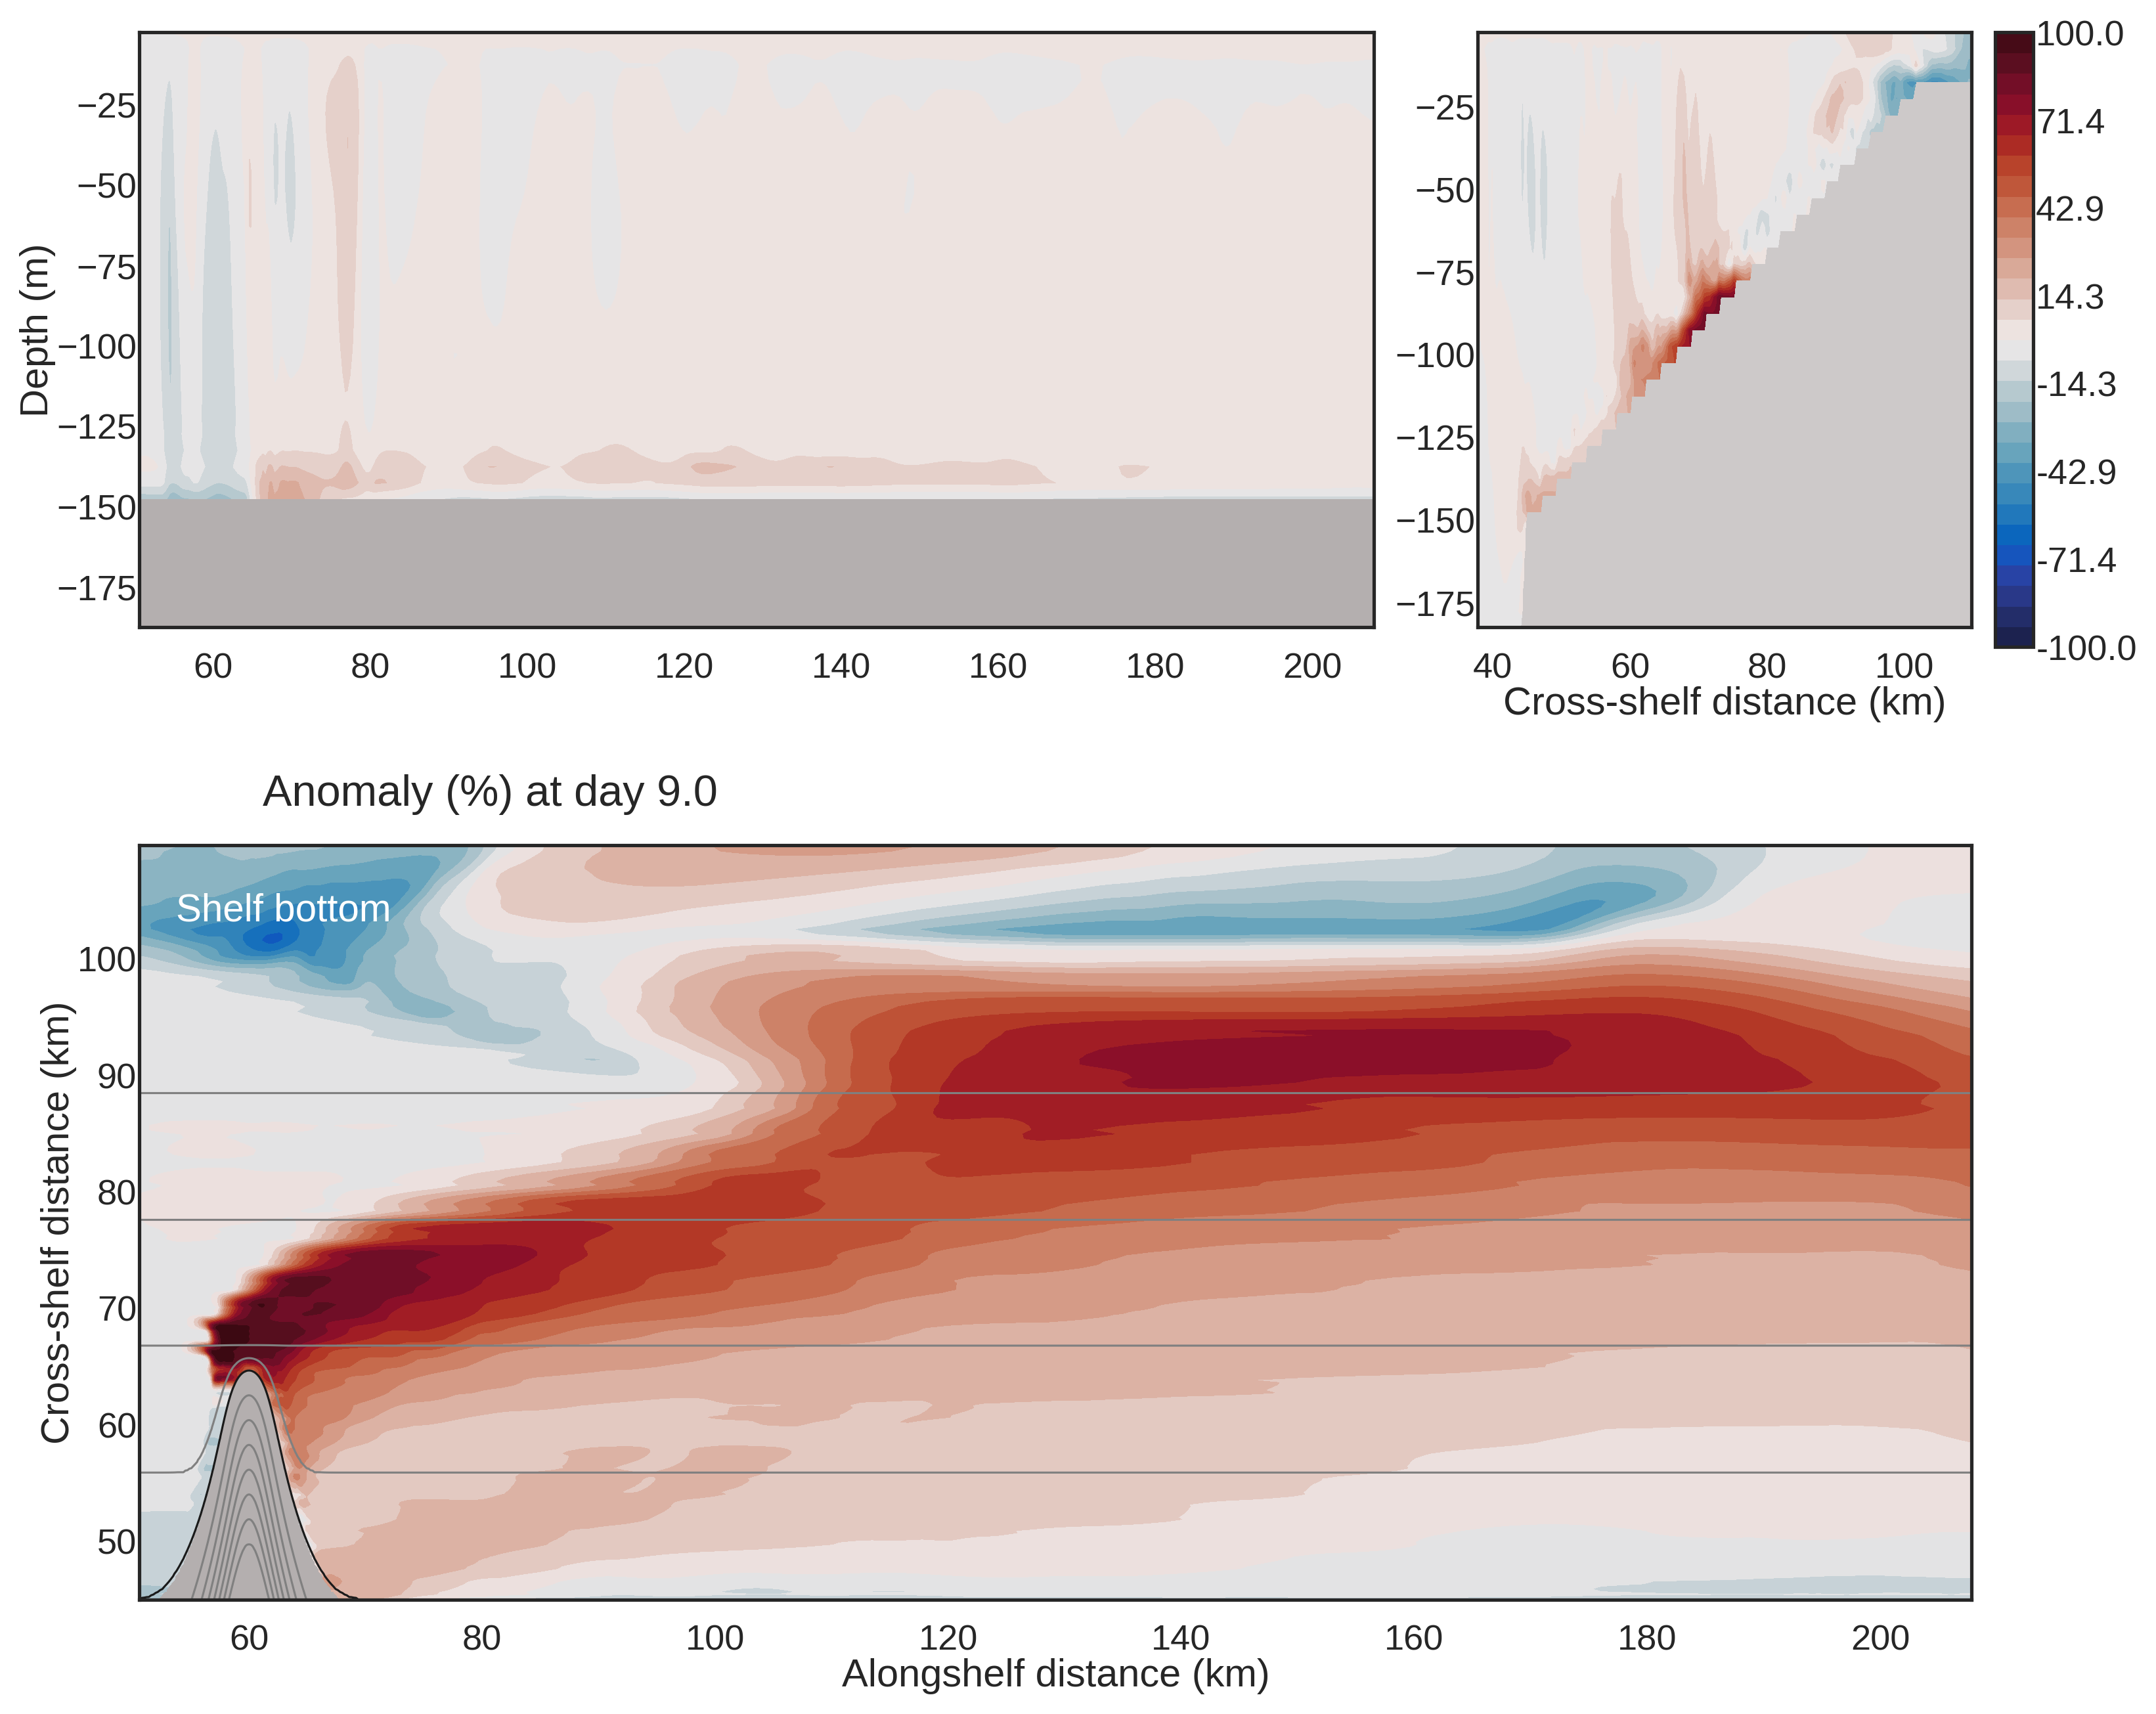

In [25]:
xslice=slice(120,500)
yslice=slice(100,360)

xind = 240
yind = 131 # y index for alongshore cross-section
zind = 38

zslice = slice(0,38)

# plot2
zslice_2 = slice(0,37)

# plot 3
yslice_bac = slice(129,360)
xslice_bac = slice(120,500)

# frames for beamer animation
dpi = 300

trac = 'Tr01' # linear

title_text = 'Anomaly (%)'

cmap_name = cmo.cm.balance
cmap_name2 = cmo.cm.balance
sns.set_context('talk')
sns.set_style('white')

plt.rcParams['font.size'] = 14.0

starttime = 0
ff = plt.figure(figsize=(12,12),dpi=dpi)
   
for tt in range(19):
    
    next_frame_anom(tt,ff, trac,Trmin=-100, Trmax=100, textt=title_text)
    frame_name2 = ('frames/LinAnom_AST_tt%02d.png' %tt) 
    plt.savefig(frame_name2,  format='png',bbox_inches='tight')
    


### Animations

2.0 8.6569
2.0 8.47699
2.0 8.6569
2.0 8.47699


/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


2.00307 8.69753
2.00307 8.47463
2.00602 8.78883
2.00592 8.45623
2.00884 8.92648
2.00815 8.4051
2.0116 9.15009
2.01122 9.49214
2.01427 9.65818
2.01332 10.5241
2.01692 10.094
2.01567 11.0228
2.01946 10.2479
2.01771 11.1958
2.02193 10.2451
2.01932 11.2514
2.02431 10.2103
2.0208 11.2409
2.02659 10.143
2.02205 11.2814
2.02882 10.0494
2.02302 11.2962
2.03097 10.0051
2.02447 11.2294
2.03303 9.95198
2.02603 11.117
2.03504 9.8868
2.0278 10.9579
2.03699 9.86048
2.02947 10.9283
2.03888 9.84169
2.03115 10.9952
2.0407 10.8294
2.03288 11.0889
2.04251 11.4407
2.03494 11.1537
2.0 8.6569
2.0 8.47699


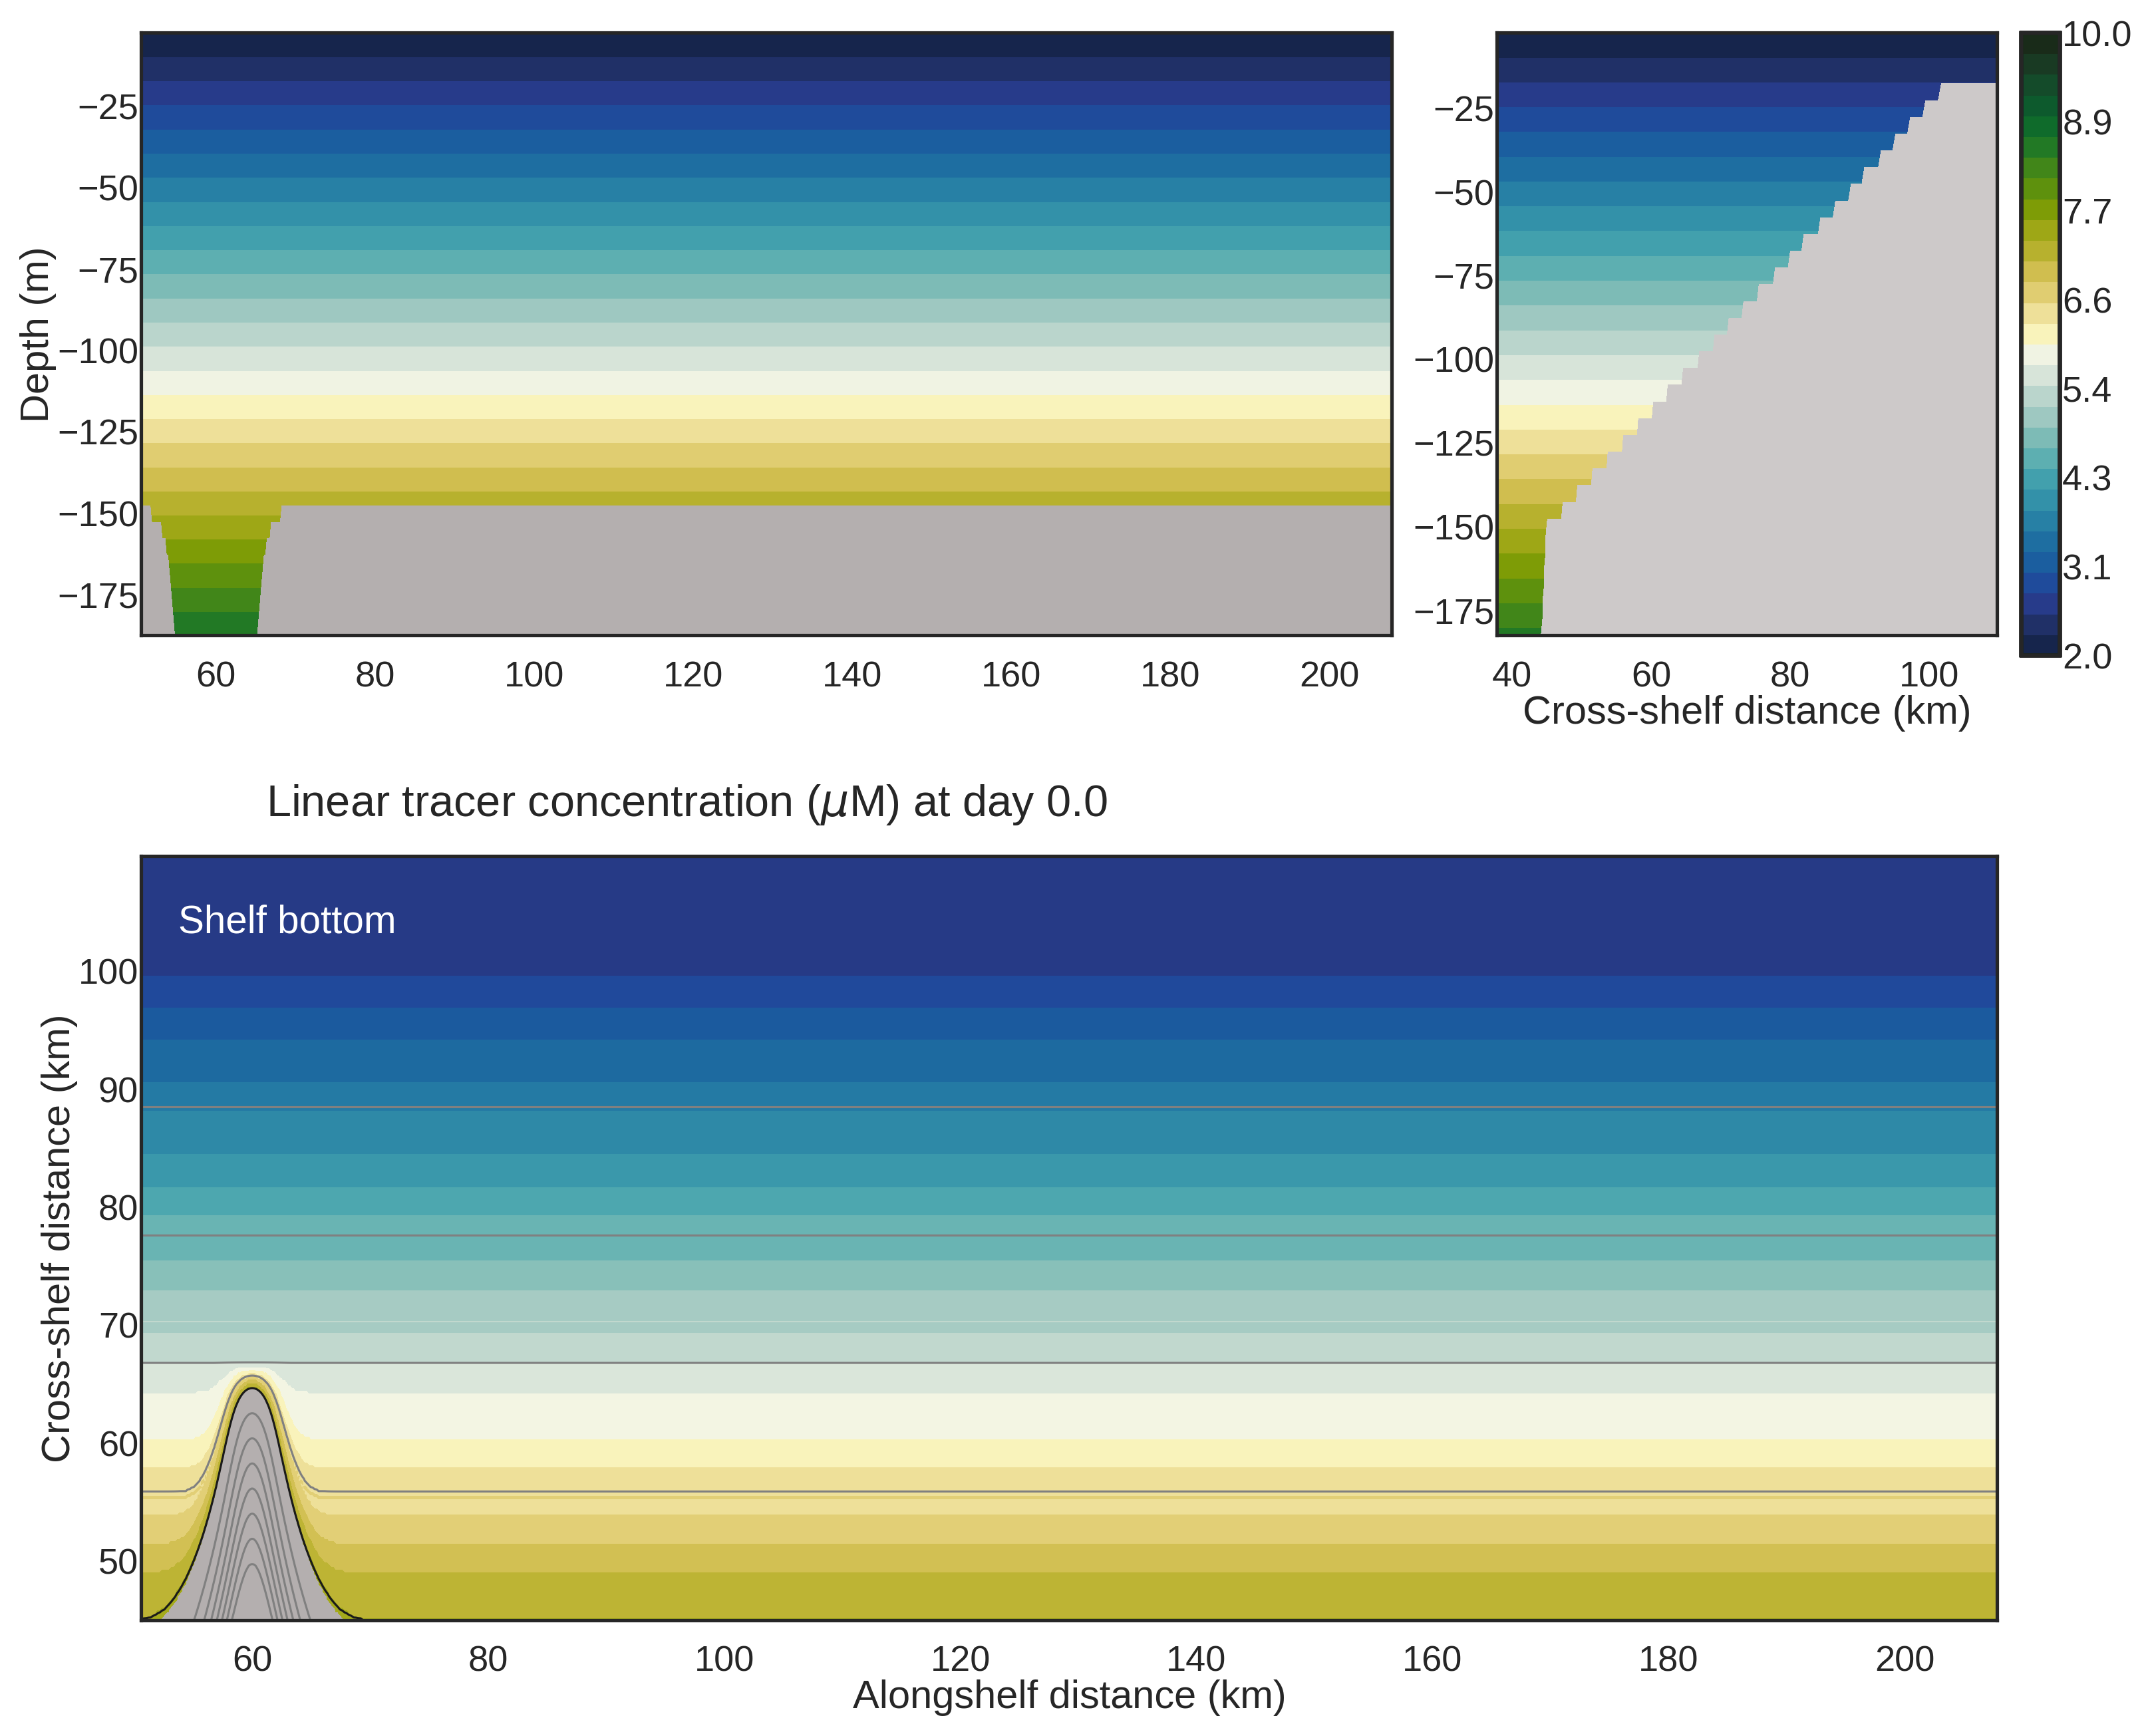

In [23]:
xslice=slice(120,500)
yslice=slice(100,360)

xind = 240
yind = 131 # y index for alongshore cross-section
zind = 38

zslice = slice(0,38)

# plot2
zslice_2 = slice(0,37)

# plot 3
yslice_bac = slice(129,360)
xslice_bac = slice(120,500)

# frames for beamer animation
dpi = 300

trac = 'Tr01' # Linear

cmap_name = cmo.cm.delta
cmap_name2 = cmo.cm.delta
sns.set_context('talk')
sns.set_style('white')

title_text = 'Linear tracer concentration ($\mu$M)'
plt.rcParams['font.size'] = 14.0

starttime = 0

ff = plt.figure(figsize=(12,12),dpi=dpi)

def init():
    next_frame(0,ff, trac, textt=title_text, Trmin=2.0, Trmax=10)
def animate(t):
    next_frame(t,ff, trac, textt=title_text, Trmin=2.0, Trmax=10)

    
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

anim = animation.FuncAnimation(ff, animate, init_func=init,frames=19,repeat=False)
anim.save('Lin_AST.mp4', writer=writer)

2.0 8.6569
2.0 8.47699


/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


2.0 8.6569
2.0 8.47699


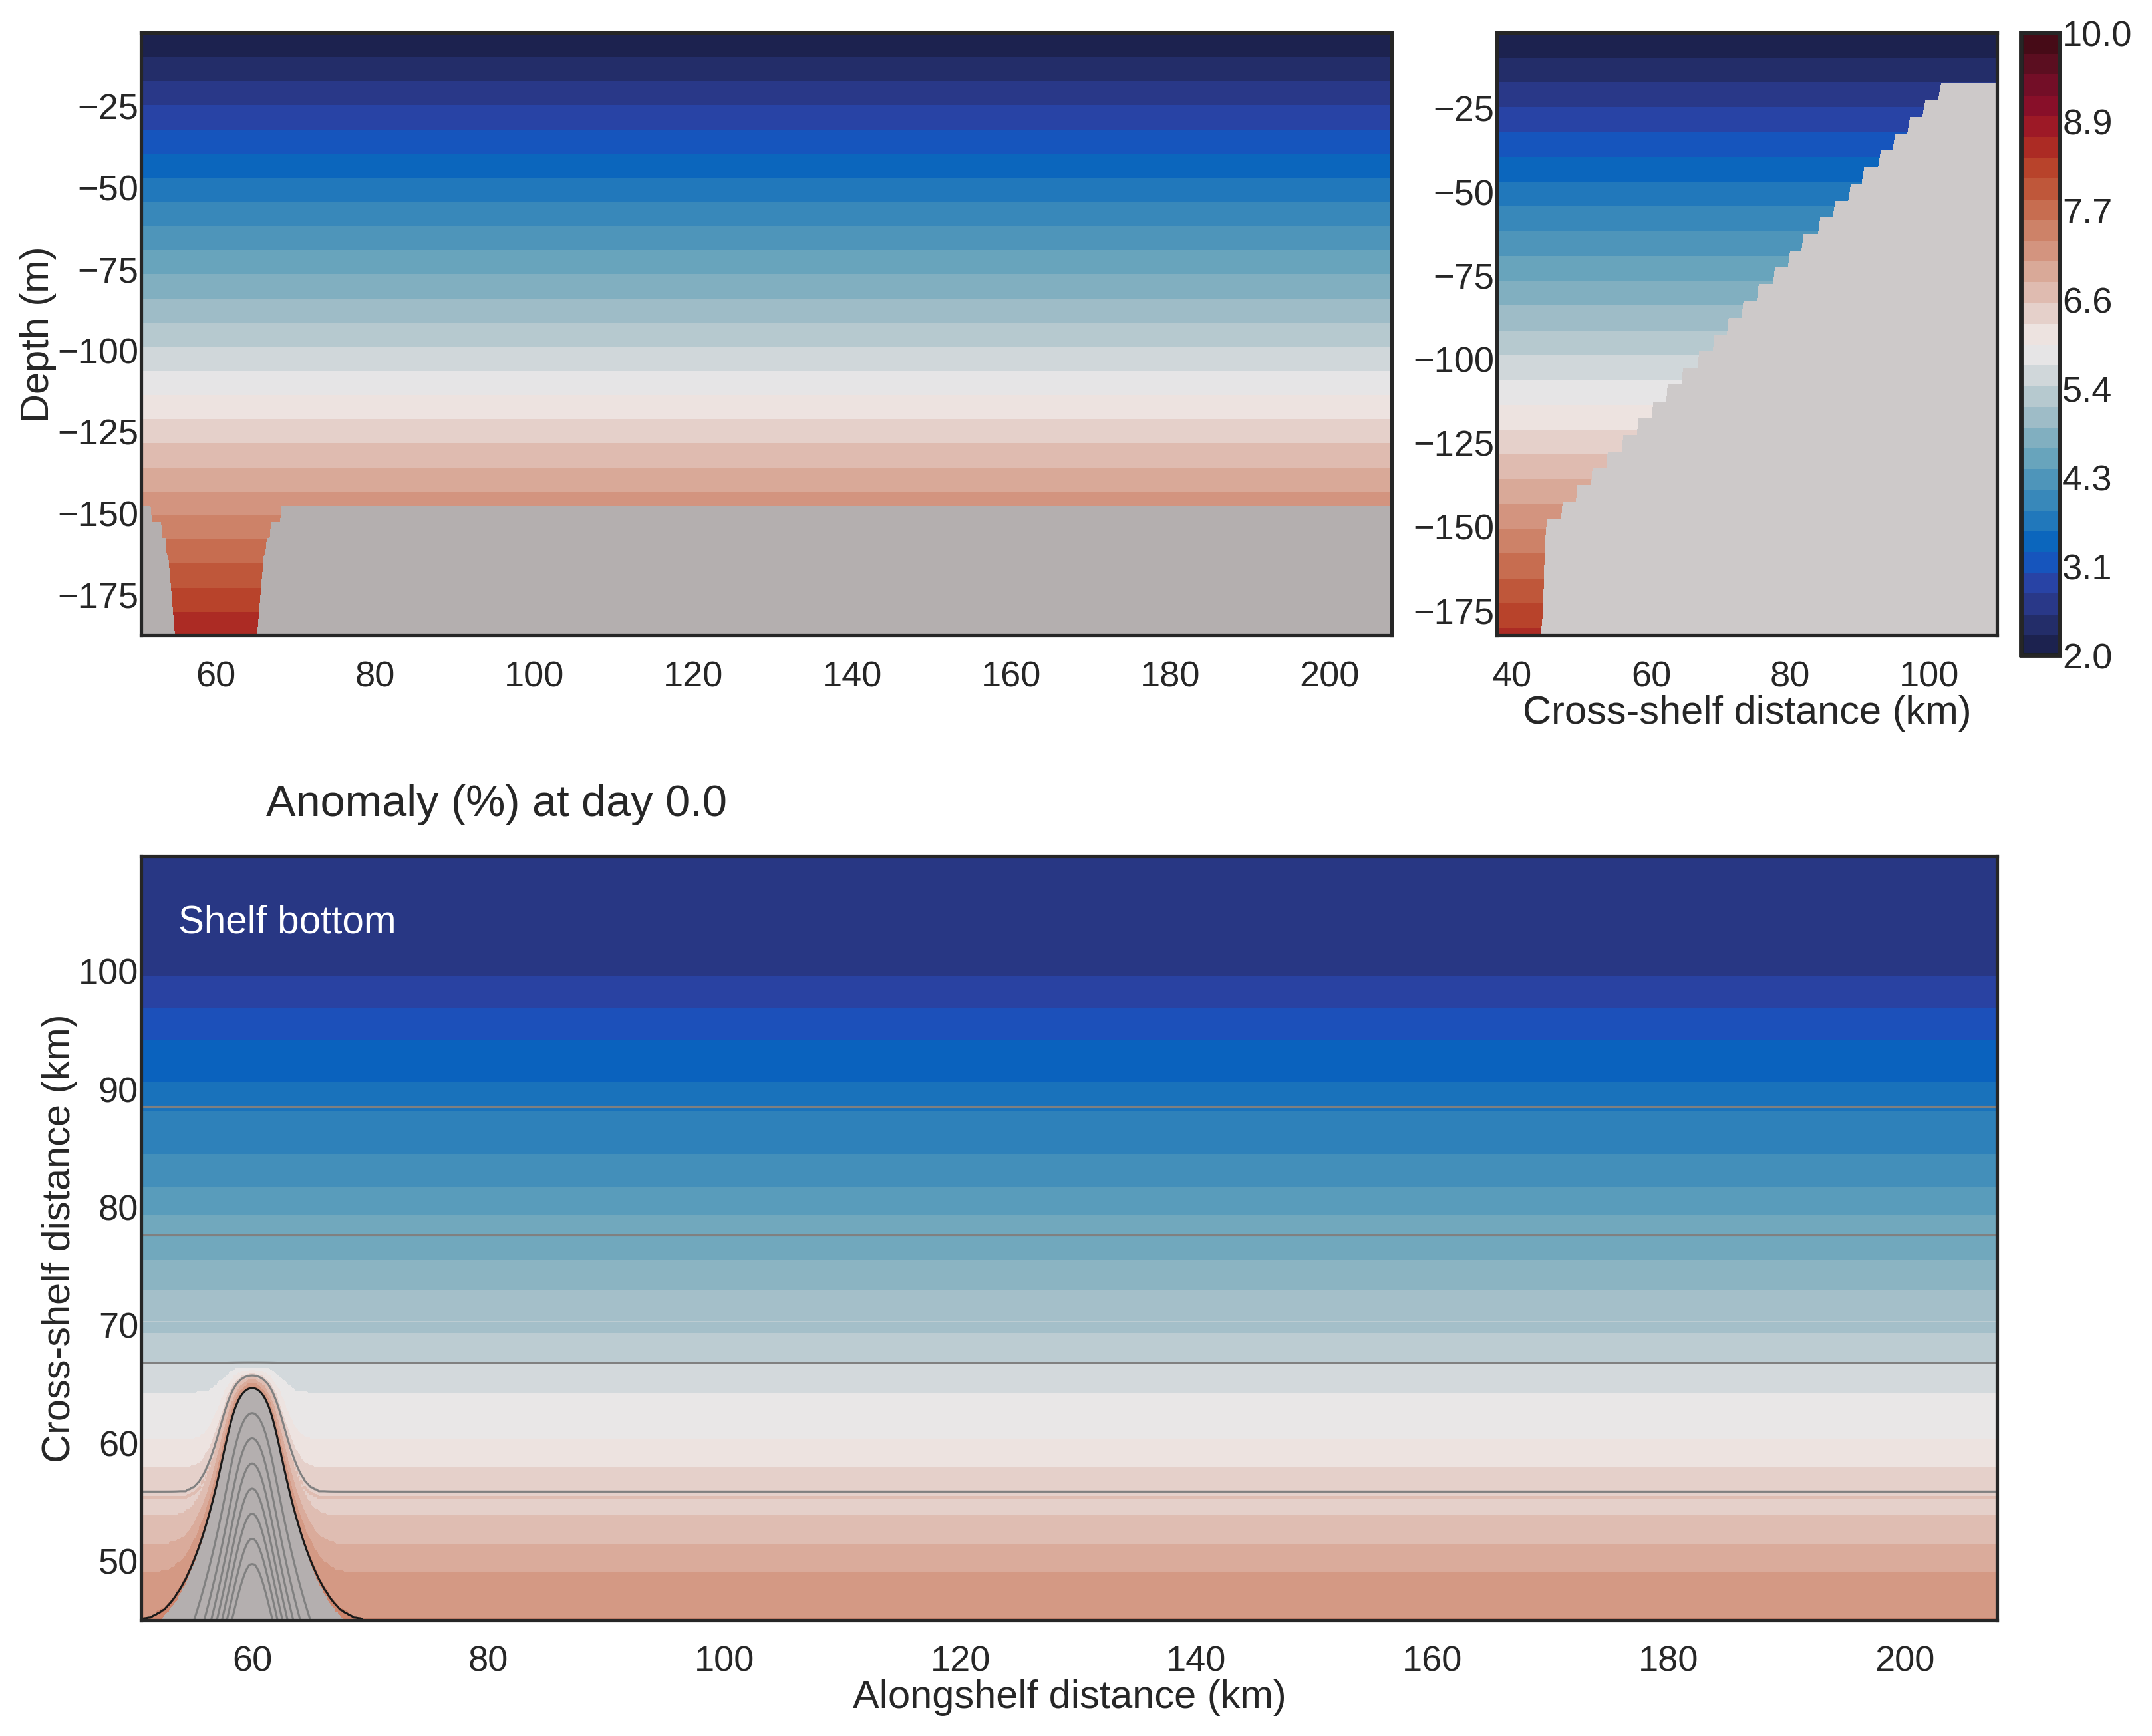

In [22]:
xslice=slice(120,500)
yslice=slice(100,360)

xind = 240
yind = 131 # y index for alongshore cross-section
zind = 38

zslice = slice(0,38)

# plot2
zslice_2 = slice(0,37)

# plot 3
yslice_bac = slice(129,360)
xslice_bac = slice(120,500)

# frames for beamer animation
dpi = 300

trac = 'Tr01' # linear

title_text = 'Anomaly (%)'

cmap_name = cmo.cm.balance
cmap_name2 = cmo.cm.balance
sns.set_context('talk')
sns.set_style('white')

plt.rcParams['font.size'] = 14.0

starttime = 0
ff = plt.figure(figsize=(12,12),dpi=dpi)

def init():
    next_frame(0,ff, trac, textt=title_text, Trmin=2.0, Trmax=10)
def animate(t):
    next_frame_anom(t,ff, trac, textt=title_text, Trmin=-100, Trmax=100)

    
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

anim = animation.FuncAnimation(ff, animate, init_func=init,frames=19,repeat=False)
anim.save('Lin_anom_AST.mp4', writer=writer)